# Setting up environment

In [ ]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import sys
import sklearn as sk
import pandas as pd
import sklearn.feature_extraction.text as sk_text
from collections.abc import Sequence
from sklearn import preprocessing, metrics
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, show
import shutil
import os
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
import io
from sklearn.model_selection import train_test_split


print("Python {}".format(sys.version))
print('Pandas {}'.format(pd.__version__))
print('Numpy {}'.format(np.__version__))
print('Scikit-Learn {}'.format(sk.__version__))
print()
print("Tensor Flow Version: {}".format(tf.__version__))

Python 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
Pandas 1.5.3
Numpy 1.23.5
Scikit-Learn 1.2.2

Tensor Flow Version: 2.13.0


# Tensorflow helper functions

In [ ]:
# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)



# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

# Importing data

In [ ]:
businesses = pd.read_json('/content/drive/MyDrive/dataset/yelp_academic_dataset_business.json', lines=True, nrows = 100000)
reviews = pd.read_json('/content/drive/MyDrive/dataset/yelp_academic_dataset_review.json', lines=True, nrows = 100000)

# Data cleaning

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
businesses = businesses[businesses['review_count'] >= 20]
businesses = businesses[['business_id', 'stars']]

reviews = reviews[['business_id', 'text']]
print(reviews.text.tolist()[0:5])

grouped_reviews = reviews.groupby('business_id')['text'].sum()
grouped_reviews_frame = pd.DataFrame({'business_id': grouped_reviews.index, 'all_reviews': grouped_reviews.values})
print(grouped_reviews_frame.head())

["If you decide to eat here, just be aware it is going to take about 2 hours from beginning to end. We have tried it multiple times, because I want to like it! I have been to it's other locations in NJ and never had a bad experience. \n\nThe food is good, but it takes a very long time to come out. The waitstaff is very young, but usually pleasant. We have just had too many experiences where we spent way too long waiting. We usually opt for another diner or restaurant on the weekends, in order to be done quicker.", "I've taken a lot of spin classes over the years, and nothing compares to the classes at Body Cycle. From the nice, clean space and amazing bikes, to the welcoming and motivating instructors, every class is a top notch work out.\n\nFor anyone who struggles to fit workouts in, the online scheduling system makes it easy to plan ahead (and there's no need to line up way in advanced like many gyms make you do).\n\nThere is no way I can write this review without giving Russell, th

# Data Setup

In [ ]:
vectorizer = sk_text.TfidfVectorizer(
                             stop_words = 'english',
                             max_features = 1000,
                             min_df = 20,
                            #  max_df = 300
                             )

reviews_vec = vectorizer.fit_transform(grouped_reviews_frame['all_reviews'])

col_id = grouped_reviews_frame['business_id']
reviews_vec_frame = pd.DataFrame(reviews_vec.todense())
tfidf_reviews_frame = pd.concat([col_id, reviews_vec_frame], axis=1)

review_agg_frame = businesses.merge(tfidf_reviews_frame, on='business_id')

display(review_agg_frame)


review_agg_frame.drop('business_id',1,inplace=True)

x,y = to_xy(review_agg_frame,"stars")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

,business_id,stars,0,1,2,3,4,5,6,7,...,990,991,992,993,994,995,996,997,998,999
0,tUFrWirKiKi_TAnsVWINQQ,3.5,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,MTSW4McQd7CbVtyjqoe9mw,4.0,0.048111,0.016732,0.000000,0.0,0.0,0.000000,0.000000,0.024278,...,0.000000,0.000000,0.039072,0.038393,0.000000,0.042126,0.000000,0.000000,0.000000,0.022562
2,il_Ro8jwPlHresjw9EGmBg,2.5,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.076107,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0bPLkL0QhhPO5kt1_EXmNQ,4.5,0.000000,0.000000,0.021369,0.0,0.0,0.000000,0.000000,0.000000,...,0.019499,0.000000,0.033007,0.000000,0.000000,0.053381,0.000000,0.000000,0.022107,0.000000
4,MUTTqe8uqyMdBl186RmNeA,4.0,0.000000,0.011479,0.017354,0.0,0.0,0.027053,0.026201,0.000000,...,0.015836,0.017092,0.026806,0.000000,0.011174,0.014451,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5413,6aoXAXNrL7KrGBVRYBMFWw,4.5,0.000000,0.004233,0.000000,0.0,0.0,0.009976,0.019323,0.006142,...,0.000000,0.006303,0.004942,0.033995,0.057685,0.015986,0.016021,0.012482,0.000000,0.000000
5414,bfY9Z5zOihXRrR2aqVqHXQ,2.5,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5415,SVdYIdv7EWVipdqT0ifIEw,4.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.064749,0.050774,0.000000,0.000000,0.054743,0.000000,0.000000,0.000000,0.000000
5416,dsn0I8baOgtiKX0NkeVguA,2.0,0.000000,0.000000,0.000000,0.0,0.0,0.124290,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


<ipython-input-9-b5d0e227d66c>:19: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  review_agg_frame.drop('business_id',1,inplace=True)


# Experiments


In [ ]:
for activation_func in ['relu', 'sigmoid', 'tanh']:
  for optimization_func in ['adam', 'sgd']:
    print('Training and testing model: 1h-large-' + activation_func + '-' + optimization_func)
    model = Sequential()
    model.add(Dense(100, input_dim=x_train.shape[1], activation=activation_func)) # Hidden 1
    # model.add(Dense(10, activation=activation_func)) # Hidden 2
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer=optimization_func)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model
    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=50)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

model.load_weights('dnn/best_weights.hdf5') # load weights from best model

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Training and testing model: 3h-large-relu-adam


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 14: early stopping
Training and testing model: 3h-large-relu-sgd
Epoch 38: early stopping
Training and testing model: 3h-large-sigmoid-adam
Epoch 15: early stopping
Training and testing model: 3h-large-sigmoid-sgd
Training and testing model: 3h-large-tanh-adam
Epoch 12: early stopping
Training and testing model: 3h-large-tanh-sgd
Epoch 34: early stopping
34/34 [==============================] - 0s 2ms/step
Score (RMSE): 0.543039083480835


# Additional Features

# Importing data

In [ ]:
businesses = pd.read_json('./drive/MyDrive/dataset/yelp_academic_dataset_business.json', lines=True, nrows=1000000)
reviews = pd.read_json('./drive/MyDrive/dataset/yelp_academic_dataset_review.json', lines=True, nrows=1000000)


# Data cleaning

In [ ]:
businesses = businesses[businesses['review_count'] >= 20]
businesses = businesses[['business_id', 'stars', 'state']]

reviews = reviews[['business_id', 'text']]

grouped_reviews = reviews.groupby('business_id')['text'].sum()
grouped_reviews_frame = pd.DataFrame({'business_id': grouped_reviews.index, 'all_reviews': grouped_reviews.values})
grouped_reviews_frame.head()

,business_id,all_reviews
0,--ZVrH2X2QXBFdCilbirsw,This place is sadly perm closed. I was hoping ...
1,--_9CAxgfXZmoFdNIRrhHA,It's a huge place. There's P.O. boxes big enou...
2,--_lZuj_WCGnDG6n0emlRg,Good deals to be had on liquidated designer cl...
3,--hF_3v1JmU9nlu4zfXJ8Q,Really excited to get healthier options on the...
4,--sXnWH9Xm6_NvIjyuA99w,Ich war das erste mal in Philadelphia und ich ...


# Data Setup

In [ ]:
vectorizer = sk_text.TfidfVectorizer(
                             stop_words = 'english',
                             max_features = 1000,
                             min_df = 20,
                            #  max_df = 300
                             )
reviews_vec = vectorizer.fit_transform(grouped_reviews_frame['all_reviews'])

vectorizer = sk_text.TfidfVectorizer()

col_id = grouped_reviews_frame['business_id']
reviews_vec_frame = pd.DataFrame(reviews_vec.todense())

tfidf_reviews_frame = pd.concat([col_id, reviews_vec_frame], axis=1)
review_agg_frame = businesses.merge(tfidf_reviews_frame, on='business_id')
encode_text_dummy(review_agg_frame, 'state')

review_agg_frame.drop('business_id',1,inplace=True)

display(review_agg_frame)

print("Review_Agg_Frame: {}".format(review_agg_frame.shape))
x,y = to_xy(review_agg_frame,'stars')

print("Shape: {}".format(x.shape))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

0        tUFrWirKiKi_TAnsVWINQQ
1        MTSW4McQd7CbVtyjqoe9mw
2        il_Ro8jwPlHresjw9EGmBg
3        0bPLkL0QhhPO5kt1_EXmNQ
4        MUTTqe8uqyMdBl186RmNeA
                  ...          
11922    tBk-uwlYrLLqjzO3CPIKjg
11923    OI2K7ao8evC5t43Pt3T4Hg
11924    YBEXgFUETJwslKr8coIZ0A
11925    F4F-jm3vmeQ38nxXViw_hA
11926    I13HqIkWfR6CydGbo9xv0A
Name: business_id, Length: 11927, dtype: object
Review_Agg_Frame: (11927, 1016)
Shape: (11927, 1015)


<ipython-input-32-12231562025a>:21: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  review_agg_frame.drop('business_id',1,inplace=True)


# 2h-optimal

*   Hidden layers: 2
*   First hidden layer: 50 nodes
*   Second hidden layer: 10 nodes



In [ ]:
one_h_optimal_rmse = {}

for activation_func in ['relu', 'sigmoid', 'tanh']:
  for optimization_func in ['adam', 'sgd']:
    print('Training and testing model: 1h-optimal-' + activation_func + '-' + optimization_func)
    model = Sequential()
    model.add(Dense(50, input_dim=x_train.shape[1], activation=activation_func)) # Hidden 1
    model.add(Dense(10, activation=activation_func))
    model.add(Dense(1)) # Output
    model.compile(loss='mean_squared_error', optimizer=optimization_func)

    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
    checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model

    model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=50)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

model.load_weights('dnn/best_weights.hdf5') # load weights from best model

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Training and testing model: 1h-optimal-relu-adam


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 16: early stopping
Training and testing model: 1h-optimal-relu-sgd
Epoch 11: early stopping
Training and testing model: 1h-optimal-sigmoid-adam
Epoch 19: early stopping
Training and testing model: 1h-optimal-sigmoid-sgd
Epoch 49: early stopping
Training and testing model: 1h-optimal-tanh-adam
Epoch 9: early stopping
Training and testing model: 1h-optimal-tanh-sgd
Epoch 23: early stopping
75/75 [==============================] - 0s 3ms/step
Score (RMSE): 0.4114876091480255


# Optimal Model


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 28: early stopping
75/75 [==============================] - 0s 2ms/step
Score (RMSE): 0.41465699672698975


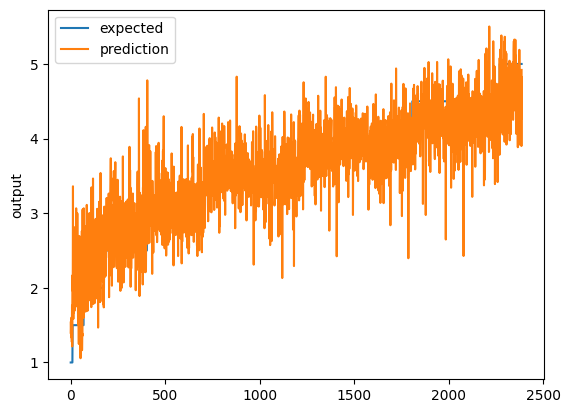

In [ ]:
model = Sequential()
model.add(Dense(50, input_dim=x_train.shape[1], activation='relu')) # Hidden 1
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='sgd')

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
checkpointer = ModelCheckpoint(filepath="dnn/best_weights.hdf5", verbose=0, save_best_only=True) # save best model
model.fit(x_train,y_train,validation_data=(x_test,y_test),callbacks=[monitor,checkpointer],verbose=0,epochs=500)    # Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch.

model.load_weights('dnn/best_weights.hdf5') # load weights from best model

# Predict and measure RMSE
pred = model.predict(x_test)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
chart_regression(pred.flatten(),y_test, sort= True)

In [ ]:
for i in range(20):
    print(f"ID {i}: Model Prediction: {pred[i]}, Actual Value: {y_test[i]}")


ID 0: Model Prediction: [4.519178], Actual Value: 4.5
ID 1: Model Prediction: [3.667065], Actual Value: 3.5
ID 2: Model Prediction: [4.4910507], Actual Value: 4.0
ID 3: Model Prediction: [2.460407], Actual Value: 3.0
ID 4: Model Prediction: [1.8241751], Actual Value: 1.5
ID 5: Model Prediction: [4.2983093], Actual Value: 4.5
ID 6: Model Prediction: [4.0904903], Actual Value: 3.5
ID 7: Model Prediction: [3.8113346], Actual Value: 4.0
ID 8: Model Prediction: [3.226604], Actual Value: 3.5
ID 9: Model Prediction: [3.151687], Actual Value: 2.5
ID 10: Model Prediction: [3.4535325], Actual Value: 3.5
ID 11: Model Prediction: [3.9873967], Actual Value: 4.0
ID 12: Model Prediction: [3.664402], Actual Value: 4.0
ID 13: Model Prediction: [1.3896382], Actual Value: 1.5
ID 14: Model Prediction: [4.1158276], Actual Value: 4.0
ID 15: Model Prediction: [3.2131264], Actual Value: 2.5
ID 16: Model Prediction: [4.1304784], Actual Value: 4.5
ID 17: Model Prediction: [4.0565734], Actual Value: 5.0
ID 18: M